# **Store Sales - Time Series Forecasting**

Acá va la introducción.

There are 6 data that we will study on them step by step.

1. *Train*
2. *Test*
3. *Store*
4. *Transactions*
5. *Holidays and Events*
6. *Daily Oil Price*


# **1. Importing Data**

In [2]:
import numpy as np
import pandas as pd

#Import
train = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/Store Sales/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/Store Sales/test.csv")
stores = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/Store Sales/stores.csv")
oil = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/Store Sales/oil.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/Store Sales/transactions.csv")
holidays_events = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/Store Sales/holidays_events.csv")

In [3]:
#Quick Scan

df = [train, test, stores, oil, transactions, holidays_events]
for i, df_item in enumerate(df):
    df_name = ["train", "test", "stores", "oil", "transactions", "holidays_events"][i]
    print(f"\033[1m{df_name}\033[0m\n")
    print(df_item.info())
    print("-" * 40,"\n")

train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
---------------------------------------- 

test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None
---------------------------------------- 

stores

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 e

In [4]:
#Datatime
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
oil["date"] = pd.to_datetime(oil["date"])
transactions["date"] = pd.to_datetime(transactions["date"])
holidays_events["date"] = pd.to_datetime(holidays_events["date"])

# **2. Exploring**

## Transactions

In [5]:
transactions.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [6]:
import plotly.express as px

#Daily transactions per Store
px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

We observed an increase in sales in the last months of the year. Let's explore more.

In [7]:
#Monthly transactions

a = transactions.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transactions")

**We validated that sales increase in December.** Let's explore how transaction volume varies by day of the month.

In [8]:
#Average daily transactions per day of the month

b = transactions.groupby([transactions['date'].dt.year.rename('year'), transactions['date'].dt.month.rename('month'), transactions['date'].dt.day.rename('day')])['transactions'].mean().reset_index()
px.bar(b, x='day', y='transactions', color='day', labels={'transactions':'Average daily transactions', 'day':'Day'}, title='Average daily transactions per day of the month')

We do not see variation by day of the month. Let's explore by day of the week instead.

In [9]:
#Daily transactions per day of the week

c = transactions.groupby([transactions['date'].dt.year.rename('year'), transactions['date'].dt.month.rename('month'), transactions['date'].dt.day_name().rename('day_of_week')])['transactions'].sum().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
px.box(c, x='day_of_week', y='transactions', color='day_of_week', category_orders={'day_of_week': day_order}, labels={'transactions', 'day_of_week'}, title='Daily transactions per day of the week', points="all")

**We verified a trend of increasing sales on weekends.**

## Oil Price

In [10]:
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [11]:
#Daily Oil Price
px.line(oil, x='date', y='dcoilwtico', title='Daily Oil Price')

To address missing values, we will use linear interpolation for this time series.

In [12]:
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate(method='linear')
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

In [13]:
oil.head()

date  dcoilwtico  dcoilwtico_interpolated
0 2013-01-01         NaN                      NaN
1 2013-01-02       93.14                93.140000
2 2013-01-03       92.97                92.970000
3 2013-01-04       93.12                93.120000
4 2013-01-05         NaN                93.146667

In [14]:
oil['dcoilwtico_interpolated'].isna().sum()


1

## Train

In [15]:
train

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

Lets graph daily total sales.

In [16]:
#Daily total sales of the stores
d = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(d, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

We verified that not all stores have sales data since January 2013, likely because new stores have been opening during that time. We will identify these rows to proceed with their removal and prevent them from affecting our model.

In [17]:
# Rows where sales are greater than zero
train_sales_zero = train[train['sales'] > 0]

# First date where sales for each store_nbr > zero
first_sale_dates = train_sales_zero.groupby('store_nbr')['date'].min().reset_index()

#Store_nbr with sales after 2013-01-02
filtered_first_sale_dates = first_sale_dates[first_sale_dates['date'] > '2013-01-02']

filtered_first_sale_dates

store_nbr       date
19         20 2015-02-13
20         21 2015-07-24
21         22 2015-10-09
28         29 2015-03-20
35         36 2013-05-09
41         42 2015-08-21
51         52 2017-04-20
52         53 2014-05-29

In [18]:
#Remove rows
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]

In [19]:
#Time Related Features
train["year"] = train.date.dt.year
test["year"] = test.date.dt.year
train["month"] = train.date.dt.month
test["month"] = test.date.dt.month
train["day"] = train.date.dt.day
test["day"] = test.date.dt.day
train["day_of_week"] = train.date.dt.dayofweek + 1
test["day_of_week"] = test.date.dt.dayofweek + 1
train["week_of_year"] = train.date.dt.dayofyear
test["week_of_year"] = test.date.dt.dayofyear
train["quarter"] = train.date.dt.quarter
test["quarter"] = test.date.dt.quarter
train["is_weekend"] = np.where(train.day_of_week.isin([5,6]), 1, 0)
test["is_weekend"] = np.where(test.day_of_week.isin([5,6]), 1, 0)
train["is_holiday"] = np.where(train.date.isin(holidays_events.date), 1, 0)
test["is_holiday"] = np.where(test.date.isin(holidays_events.date), 1, 0)

## Seasons
conditions_train = [train["month"].isin([12, 1, 2]), train["month"].isin([3, 4, 5]), train["month"].isin([6, 7, 8]), train["month"].isin([9, 10, 11])]
conditions_test = [test["month"].isin([12, 1, 2]), test["month"].isin([3, 4, 5]), test["month"].isin([6, 7, 8]), test["month"].isin([9, 10, 11])]
choices = [0, 1, 2, 3] # 0 = winter, 1 = spring, 2 = summer, 3 = autumn
train["season"] = np.select(conditions_train, choices, default=np.nan)
test["season"] = np.select(conditions_test, choices, default=np.nan)


In [20]:
train.head()

id       date  store_nbr      family  sales  onpromotion  year  month  day  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  2013      1    1   
1   1 2013-01-01          1   BABY CARE    0.0            0  2013      1    1   
2   2 2013-01-01          1      BEAUTY    0.0            0  2013      1    1   
3   3 2013-01-01          1   BEVERAGES    0.0            0  2013      1    1   
4   4 2013-01-01          1       BOOKS    0.0            0  2013      1    1   

   day_of_week  week_of_year  quarter  is_weekend  is_holiday  season  
0            2             1        1           0           1     0.0  
1            2             1        1           0           1     0.0  
2            2             1        1           0           1     0.0  
3            2             1        1           0           1     0.0  
4            2             1        1           0           1     0.0

## Stores

Lets explore this data set:

In [21]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [22]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [23]:
print(stores.city.unique())
print(stores.city.nunique())
print(stores.state.unique())
print(stores.state.nunique())
print(stores.type.unique())
print(stores.type.nunique())
print(stores.cluster.unique())
print(stores.cluster.nunique())

['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
22
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
16
['D' 'B' 'C' 'E' 'A']
5
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]
17


It tells us about the locations of the stores, there are no null variables and they are well defined. These data will be crucial for our analysis, we will use them later

## Holidays and Events

Lets explore this data set:

In [24]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [25]:
holidays_events.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [26]:
print(holidays_events.date.nunique())
print(holidays_events.type.unique())
print(holidays_events.type.nunique())
print(holidays_events.locale.unique())
print(holidays_events.locale.nunique())
print(holidays_events.locale_name.unique())
print(holidays_events.locale_name.nunique())
print(holidays_events.description.unique())
print(holidays_events.description.nunique())

312
['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
6
['Local' 'Regional' 'National']
3
['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
24
['Fundacion de Manta' 'Provincializacion de Cotopaxi'
 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Provincializacion de Imbabura'
 'Cantonizacion de Latacunga' 'Fundacion de Machala'
 'Fundacion de Santo Domingo' 'Cantonizacion de El Carmen'
 'Cantonizacion de Cayambe' 'Fundacion de Esmeraldas'
 'Primer Grito de Independencia' 'Fundacion de Riobamba'
 'Fundacion de Ambato' 'Fundacion de Ibarra' 'Cantonizacion de Quevedo'
 'Independencia de Guayaquil' 'Traslado Independencia de Guayaquil'
 'Dia de Difuntos' 'Independen


Here we realize that when the holiday is national, it affects all localities; that in this dataframe, the data in 'local_name' with the 'regional' locale matches the data in the 'state' column in the 'stores' dataframe; and that the data in 'local_name' with the 'local' locale matches the data in the 'city' column in the 'stores' dataframe. This is without any exception.

Let's make some arrangements.

About Holidays:

In [27]:
# Transferred Holidays
transf_1 = holidays_events[(holidays_events.type == "Holiday") & (holidays_events.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
transf_2 = holidays_events[(holidays_events.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
transf = pd.concat([transf_1,transf_2], axis = 1)
transf = transf.iloc[:, [5,1,2,3,4]]

holidays_events = holidays_events[(holidays_events.transferred == False) & (holidays_events.type != "Transfer")].drop("transferred", axis=1)
holidays_events = pd.concat([holidays_events, transf], ignore_index=True)

# Additional Holidays
holidays_events["description"] = holidays_events["description"].str.replace(r'(\+|-)\d*$', '', regex=True)
holidays_events["type"] = np.where(holidays_events["type"] == "Additional", "Holiday", holidays_events["type"])

# Bridge Holidays
holidays_events["description"] = holidays_events["description"].str.replace("Puente ", "")
holidays_events["type"] = np.where(holidays_events["type"] == "Bridge", "Holiday", holidays_events["type"])

# Work Day Holidays, that is meant to payback the Bridge. Do not do anything.

holidays_events.head()


date     type    locale locale_name                    description
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba

About the locale:

In [28]:
# Separate the holidays ccording to locale
holidays_national = holidays_events.loc[holidays_events['locale'] == 'National'].copy()
holidays_regional = holidays_events.loc[holidays_events['locale'] == 'Regional'].copy()
holidays_local = holidays_events.loc[holidays_events['locale'] == 'Local'].copy()

# Show results
print("\033[1mholidays_national:\033[0m\n")
print(holidays_national['description'].unique())
print(holidays_national['description'].nunique())
print("\n\033[1mholidays_regional:\033[0m\n")
print(holidays_regional['description'].unique())
print(holidays_regional['description'].nunique())
print("\n\033[1mholidays_local:\033[0m\n")
print(holidays_local['description'].unique())
print(holidays_local['description'].nunique())

holidays_national:

['Primer Grito de Independencia' 'Dia de Difuntos'
 'Independencia de Cuenca' 'Navidad' 'Primer dia del ano'
 'Recupero puente Navidad' 'Recupero puente primer dia del ano' 'Carnaval'
 'Viernes Santo' 'Dia del Trabajo' 'Dia de la Madre'
 'Batalla de Pichincha' 'Inauguracion Mundial de futbol Brasil'
 'Mundial de futbol Brasil: Ecuador-Suiza'
 'Mundial de futbol Brasil: Ecuador-Honduras'
 'Mundial de futbol Brasil: Ecuador-Francia'
 'Mundial de futbol Brasil: Octavos de Final'
 'Mundial de futbol Brasil: Cuartos de Final'
 'Mundial de futbol Brasil: Semifinales'
 'Mundial de futbol Brasil: Tercer y cuarto lugar'
 'Mundial de futbol Brasil: Final' 'Black Friday' 'Cyber Monday'
 'Recupero Navidad' 'Recupero Primer dia del ano'
 'Independencia de Guayaquil' 'Terremoto Manabi'
 'Recupero Dia de Difuntos']
28

holidays_regional:

['Provincializacion de Cotopaxi' 'Provincializacion de Imbabura'
 'Provincializacion de Santo Domingo' 'Provincializacion Santa Elena']
4

holid

In [29]:
holidays_national.head()

date     type    locale locale_name                    description
14 2012-08-10  Holiday  National     Ecuador  Primer Grito de Independencia
19 2012-11-02  Holiday  National     Ecuador                Dia de Difuntos
20 2012-11-03  Holiday  National     Ecuador        Independencia de Cuenca
29 2012-12-21  Holiday  National     Ecuador                        Navidad
31 2012-12-22  Holiday  National     Ecuador                        Navidad

We prepare the data in such a way that the type of holiday can be a feature of the date and according to the locality it affects.

In [30]:
# Create binary columns for para holidays_national
holidays_national_dummies = pd.get_dummies(holidays_national['description']).astype(int)
holidays_national_dummies['date'] = holidays_national['date']
holidays_national_dummies = holidays_national_dummies.groupby('date').max().reset_index()

# Create binary columns for para holidays_regional
holidays_regional_dummies = pd.get_dummies(holidays_regional['description']).astype(int)
holidays_regional_dummies['date'] = holidays_regional['date']
holidays_regional_dummies = holidays_regional_dummies.groupby('date').max().reset_index()

# Create binary columns for para holidays_local
holidays_local_dummies = pd.get_dummies(holidays_local['description']).astype(int)
holidays_local_dummies['date'] = holidays_local['date']
holidays_local_dummies = holidays_local_dummies.groupby('date').max().reset_index()

# Delete the description column from the original DataFrames
holidays_national.drop(columns=['description', 'type', 'locale', 'locale_name'], inplace=True)
holidays_regional.drop(columns=['description', 'type', 'locale'], inplace=True)
holidays_local.drop(columns=['description', 'type', 'locale'], inplace=True)

# Rename the locale_name columns to regional and local
holidays_regional.rename(columns={'locale_name': 'state'}, inplace=True)
holidays_local.rename(columns={'locale_name': 'city'}, inplace=True)

# Merge original DataFrames with binary columns
holidays_national = pd.merge(holidays_national, holidays_national_dummies, on='date', how='left')
holidays_regional = pd.merge(holidays_regional, holidays_regional_dummies, on='date', how='left')
holidays_local = pd.merge(holidays_local, holidays_local_dummies, on='date', how='left')

# Show examples of the new DataFrames
print("\033[1mholidays_national:\033[0m\n")
print(holidays_national.head())
print("\n\033[1mholidays_regional:\033[0m\n")
print(holidays_regional.head())
print("\n\033[1mholidays_local:\033[0m\n")
print(holidays_local.head())

holidays_national:

        date  Batalla de Pichincha  Black Friday  Carnaval  Cyber Monday  \
0 2012-08-10                     0             0         0             0   
1 2012-11-02                     0             0         0             0   
2 2012-11-03                     0             0         0             0   
3 2012-12-21                     0             0         0             0   
4 2012-12-22                     0             0         0             0   

   Dia de Difuntos  Dia de la Madre  Dia del Trabajo  \
0                0                0                0   
1                1                0                0   
2                0                0                0   
3                0                0                0   
4                0                0                0   

   Inauguracion Mundial de futbol Brasil  Independencia de Cuenca  ...  \
0                                      0                        0  ...   
1                                     

# **3. Building Models**

What we will do is try to merge train and test with transactions, oil, stores, holidays_national, holidays_regional, and holidays_local. As we explained earlier, what we want is for transactions, oil, and the other dataframes to function as features of the sales we want to train and predict (dependent variables), so that we can then apply the models.

In [31]:
# Merge the dataframes
train_mix = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')
test_mix = pd.merge(test, transactions, on=['date', 'store_nbr'], how='left')
train_mix = pd.merge(train_mix, oil[['date', 'dcoilwtico_interpolated']], on='date', how='left')
test_mix = pd.merge(test_mix, oil[['date', 'dcoilwtico_interpolated']], on='date', how='left')
train_mix = pd.merge(train_mix, stores, on='store_nbr', how='left')
test_mix = pd.merge(test_mix, stores, on='store_nbr', how='left')
train_mix = pd.merge(train_mix, holidays_national, on=['date'], how='left')
test_mix = pd.merge(test_mix, holidays_national, on=['date'], how='left')
train_mix = pd.merge(train_mix, holidays_regional, on=['date', 'state'], how='left')
test_mix = pd.merge(test_mix, holidays_regional, on=['date', 'state'], how='left')
train_mix = pd.merge(train_mix, holidays_local, on=['date', 'city'], how='left')
test_mix = pd.merge(test_mix, holidays_local, on=['date', 'city'], how='left')

# Delete the rows where 'date' is equal to '2013-01-01' due to missing data in the gas price
train_mix = train_mix[train_mix['date'] != '2013-01-01']

# Delete the date type columns (the models only accept integer or float values)
train_mix.drop(['date'], axis=1, inplace=True)
test_mix.drop(['date'], axis=1, inplace=True)

# Fill the missing values with zeros
train_mix = train_mix.fillna(0)
test_mix = test_mix.fillna(0)

train_mix.head()

id  store_nbr      family   sales  onpromotion  year  month  day  \
1518  1782          1  AUTOMOTIVE     2.0            0  2013      1    2   
1519  1783          1   BABY CARE     0.0            0  2013      1    2   
1520  1784          1      BEAUTY     2.0            0  2013      1    2   
1521  1785          1   BEVERAGES  1091.0            0  2013      1    2   
1522  1786          1       BOOKS     0.0            0  2013      1    2   

      day_of_week  week_of_year  ...  Fundacion de Ibarra  Fundacion de Loja  \
1518            3             2  ...                  0.0                0.0   
1519            3             2  ...                  0.0                0.0   
1520            3             2  ...                  0.0                0.0   
1521            3             2  ...                  0.0                0.0   
1522            3             2  ...                  0.0                0.0   

      Fundacion de Machala  Fundacion de Manta  Fundacion de Quito  \
1518                   0.0                 0.0                 0.0   
1519                   0.0                 0.0                 0.0   
1520                   0.0                 0.0                 0.0   
1521                   0.0                 0.0                 0.0   
1522                   0.0                 0.0                 0.0   

      Fundacion de Riobamba Fundacion de Santo Domingo  \
1518                    0.0                        0.0   
1519                    0.0                        0.0   
1520                    0.0                        0.0   
1521                    0.0                        0.0   
1522                    0.0                        0.0   

     Independencia de Ambato Independencia de Guaranda  \
1518                     0.0                       0.0   
1519                     0.0                       0.0   
1520                     0.0                       0.0   
1521                     0.0                       0.0   
1522                     0.0                       0.0   

      Independencia de Latacunga  
1518                         0.0  
1519                         0.0  
1520                         0.0  
1521                         0.0  
1522                         0.0  

[5 rows x 75 columns]

Encode variables and prepare to apply the models.

In [32]:
# Import the LabelEncoder library to encode some columns and optimize the data
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# List of columns to encode
columns_to_encode = ['family', 'city', 'state', 'type']

# Iterate over the columns and apply the LabelEncoder
for col in columns_to_encode:
    train_mix[col] = label_encoder.fit_transform(train_mix[col])
    test_mix[col] = label_encoder.fit_transform(test_mix[col])


Column name normalization.

In [33]:
# Replace spaces with underscores and convert to lowercase
column_names = train_mix.columns
column_names2 = test_mix.columns
clean_column_names = [col.replace(':', '_').replace(' ', '_').replace('-', '_') for col in column_names]
clean_column_names2 = [col.replace(':', '_').replace(' ', '_').replace('-', '_') for col in column_names2]

# Rename the columns in the dataframes
train_mix.columns = clean_column_names
test_mix.columns = clean_column_names2


Based on the premise that "the demand for each product in each store should exhibit distinct behavior," we will create a dataframe for each store (54) and each product family (33).

In [34]:
# Create a list to store all the dataframes
dataframes_list = []

# Get unique values of store_nbr and family
store_nbr_values = train_mix['store_nbr'].unique()
family_values = train_mix['family'].unique()


# Iterate over all combinations of store_nbr and family
for store_nbr in store_nbr_values:
    for family in family_values:
        # Filter the original dataframe for each combination
        df_name = f"train_mix_{store_nbr}_{family}"
        filtered_df = train_mix[(train_mix['store_nbr'] == store_nbr) & (train_mix['family'] == family)]

        # Add the filtered dataframe to the list of dataframes
        dataframes_list.append((df_name, filtered_df))

        # Assign the dataframe as a global variable
        globals()[df_name] = filtered_df

Our goal is to train and evaluate multiple regression models to predict sales based on different features for each combination of store and product family. We will use algorithms such as Decision Tree, Random Forest, Gradient Boosting, Support Vector Regressor (SVR), and XGBoost. We will calculate the Root Mean Squared Log Error (RMSLE) to assess the performance of each model on the train_mix dataset. The data will be split into training and test sets for each combination, and the models will be trained on the training set and evaluated on the test set. Any errors encountered during prediction will be handled and logged.

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor

rmsle_decision_tree = {}
rmsle_random_forest = {}
rmsle_gradient_boosting = {}
rmsle_svr = {}
rmsle_xgb = {}

# Function to train and evaluate a regression model
def train_and_evaluate_reg(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ensure predicted values are non-negative (Sales)
    y_pred = np.maximum(y_pred, 0)

    rmsle = mean_squared_log_error(y_test, y_pred)
    return rmsle

for store_nbr in store_nbr_values:
    for family in family_values:
        # Get the corresponding dataframe
        df_name = f"train_mix_{store_nbr}_{family}"
        df = globals()[df_name]

        # Predictor variables and target variable
        X = df[['store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend',
       'is_holiday', 'season', 'transactions', 'dcoilwtico_interpolated',
       'city', 'state', 'type', 'cluster', 'Batalla_de_Pichincha',
       'Black_Friday', 'Carnaval', 'Cyber_Monday', 'Dia_de_Difuntos',
       'Dia_de_la_Madre', 'Dia_del_Trabajo',
       'Inauguracion_Mundial_de_futbol_Brasil', 'Independencia_de_Cuenca',
       'Independencia_de_Guayaquil',
       'Mundial_de_futbol_Brasil__Cuartos_de_Final',
       'Mundial_de_futbol_Brasil__Ecuador_Francia',
       'Mundial_de_futbol_Brasil__Ecuador_Honduras',
       'Mundial_de_futbol_Brasil__Ecuador_Suiza',
       'Mundial_de_futbol_Brasil__Final',
       'Mundial_de_futbol_Brasil__Octavos_de_Final',
       'Mundial_de_futbol_Brasil__Semifinales',
       'Mundial_de_futbol_Brasil__Tercer_y_cuarto_lugar', 'Navidad',
       'Primer_Grito_de_Independencia', 'Primer_dia_del_ano',
       'Recupero_Dia_de_Difuntos', 'Recupero_Navidad',
       'Recupero_Primer_dia_del_ano', 'Recupero_puente_Navidad',
       'Recupero_puente_primer_dia_del_ano', 'Terremoto_Manabi',
       'Viernes_Santo', 'Provincializacion_Santa_Elena',
       'Provincializacion_de_Cotopaxi', 'Provincializacion_de_Imbabura',
       'Provincializacion_de_Santo_Domingo', 'Cantonizacion_de_Cayambe',
       'Cantonizacion_de_El_Carmen', 'Cantonizacion_de_Guaranda',
       'Cantonizacion_de_Latacunga', 'Cantonizacion_de_Libertad',
       'Cantonizacion_de_Quevedo', 'Cantonizacion_de_Riobamba',
       'Cantonizacion_de_Salinas', 'Cantonizacion_del_Puyo',
       'Fundacion_de_Ambato', 'Fundacion_de_Cuenca', 'Fundacion_de_Esmeraldas',
       'Fundacion_de_Guayaquil', 'Fundacion_de_Ibarra', 'Fundacion_de_Loja',
       'Fundacion_de_Machala', 'Fundacion_de_Manta', 'Fundacion_de_Quito',
       'Fundacion_de_Riobamba', 'Fundacion_de_Santo_Domingo',
       'Independencia_de_Ambato', 'Independencia_de_Guaranda',
       'Independencia_de_Latacunga']]
        y = df['sales']

        try:
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Decision Tree Regressor
            decision_tree = DecisionTreeRegressor(random_state=42)
            rmsle_decision_tree[df_name] = train_and_evaluate_reg(decision_tree, X_train, y_train, X_test, y_test)

            # Random Forest Regressor
            random_forest = RandomForestRegressor(random_state=42)
            rmsle_random_forest[df_name] = train_and_evaluate_reg(random_forest, X_train, y_train, X_test, y_test)

            # Gradient Boosting Regressor
            gradient_boosting = GradientBoostingRegressor(random_state=42)
            rmsle_gradient_boosting[df_name] = train_and_evaluate_reg(gradient_boosting, X_train, y_train, X_test, y_test)

            # SVR - Support Vector Regressor
            svr = SVR(kernel='rbf')  # Puedes probar diferentes kernels como 'linear', 'poly', 'rbf', etc.
            rmsle_svr[df_name] = train_and_evaluate_reg(svr, X_train, y_train, X_test, y_test)

            # XGBoost
            xgb = XGBRegressor(random_state=42)
            rmsle_xgb[df_name] = train_and_evaluate_reg(xgb, X_train, y_train, X_test, y_test)

            # Print progress
            print(f"Metrics obtained for {df_name}")

        except Exception as e:
            print(f"Error in prediction for {df_name}: {e}")


Metrics obtained for train_mix_1_0
Metrics obtained for train_mix_1_1
Metrics obtained for train_mix_1_2
Metrics obtained for train_mix_1_3
Metrics obtained for train_mix_1_4
Metrics obtained for train_mix_1_5
Metrics obtained for train_mix_1_6
Metrics obtained for train_mix_1_7
Metrics obtained for train_mix_1_8
Metrics obtained for train_mix_1_9
Metrics obtained for train_mix_1_10
Metrics obtained for train_mix_1_11
Metrics obtained for train_mix_1_12
Metrics obtained for train_mix_1_13
Metrics obtained for train_mix_1_14
Metrics obtained for train_mix_1_15
Metrics obtained for train_mix_1_16
Metrics obtained for train_mix_1_17
Metrics obtained for train_mix_1_18
Metrics obtained for train_mix_1_19
Metrics obtained for train_mix_1_20
Metrics obtained for train_mix_1_21
Metrics obtained for train_mix_1_22
Metrics obtained for train_mix_1_23
Metrics obtained for train_mix_1_24
Metrics obtained for train_mix_1_25
Metrics obtained for train_mix_1_26
Metrics obtained for train_mix_1_27
Me

Next, we will build a dataframe with all the evaluation results (RMSLE) for better visualization.

In [36]:
# Convert RMSLE dictionaries to DataFrames
df_decision_tree = pd.DataFrame(rmsle_decision_tree.items(), columns=['df_name', 'rmsle_decision_tree'])
df_random_forest = pd.DataFrame(rmsle_random_forest.items(), columns=['df_name', 'rmsle_random_forest'])
df_gradient_boosting = pd.DataFrame(rmsle_gradient_boosting.items(), columns=['df_name', 'rmsle_gradient_boosting'])
df_svr = pd.DataFrame(rmsle_svr.items(), columns=['df_name', 'rmsle_svr'])
df_xgb = pd.DataFrame(rmsle_xgb.items(), columns=['df_name', 'rmsle_xgb'])

df_results = df_decision_tree.merge(df_random_forest, on='df_name')
df_results = df_results.merge(df_gradient_boosting, on='df_name')
df_results['rmsle_svr'] = df_svr['rmsle_svr']
df_results['rmsle_xgb'] = df_xgb['rmsle_xgb']

df_results.set_index('df_name', inplace=True)

In [37]:
df_results

rmsle_decision_tree  rmsle_random_forest  \
df_name                                                     
train_mix_1_0               0.781626             0.490345   
train_mix_1_1               0.000000             0.000000   
train_mix_1_2               0.589544             0.377672   
train_mix_1_3               0.193689             0.033827   
train_mix_1_4               0.066088             0.027932   
...                              ...                  ...   
train_mix_52_28             0.027825             0.018743   
train_mix_52_29             0.040746             0.024468   
train_mix_52_30             0.015723             0.012800   
train_mix_52_31             0.883177             0.710988   
train_mix_52_32             0.228156             0.195317   

                 rmsle_gradient_boosting  rmsle_svr  rmsle_xgb  
df_name                                                         
train_mix_1_0                   0.467422   0.470251   0.544872  
train_mix_1_1                   0.000000   0.000000   0.000000  
train_mix_1_2                   0.348805   0.358215   0.388806  
train_mix_1_3                   0.031077   0.271515   0.023435  
train_mix_1_4                   0.031966   0.050022   0.038471  
...                                  ...        ...        ...  
train_mix_52_28                 0.021743   0.050728   0.017710  
train_mix_52_29                 0.043917   0.034852   0.034138  
train_mix_52_30                 0.013772   0.073499   0.012727  
train_mix_52_31                 0.777695   1.954119   0.817441  
train_mix_52_32                 0.247398   0.234314   0.223312  

[1782 rows x 5 columns]

Finally, we will choose which model gives us the lowest RMSLE for each subset of data.

In [38]:
# Initialize lists to store the results
df_name_list = []
rmsle_list = []
modelo_list = []

# Iterate over each row in the df_results DataFrame
for index, row in df_results.iterrows():
    # Get the minimum RMSLE value for this row
    min_rmsle = np.min(row[['rmsle_decision_tree', 'rmsle_random_forest', 'rmsle_gradient_boosting', 'rmsle_svr', 'rmsle_xgb']])

    # Determine which model gave the minimum RMSLE
    if min_rmsle == row['rmsle_decision_tree']:
        modelo = 'rmsle_decision_tree'
    elif min_rmsle == row['rmsle_random_forest']:
        modelo = 'rmsle_random_forest'
    elif min_rmsle == row['rmsle_gradient_boosting']:
        modelo = 'rmsle_gradient_boosting'
    elif min_rmsle == row['rmsle_svr']:
        modelo = 'rmsle_svr'
    elif min_rmsle == row['rmsle_xgb']:
        modelo = 'rmsle_xgb'

    # Add data to the lists
    df_name_list.append(index)
    rmsle_list.append(min_rmsle)
    modelo_list.append(modelo)

# Create the Best Result DataFrame
df_best_result = pd.DataFrame({
    'df_name': df_name_list,
    'rmsle': rmsle_list,
    'modelo': modelo_list
})

df_best_result

df_name     rmsle                   modelo
0       train_mix_1_0  0.467422  rmsle_gradient_boosting
1       train_mix_1_1  0.000000      rmsle_decision_tree
2       train_mix_1_2  0.348805  rmsle_gradient_boosting
3       train_mix_1_3  0.023435                rmsle_xgb
4       train_mix_1_4  0.027932      rmsle_random_forest
...               ...       ...                      ...
1777  train_mix_52_28  0.017710                rmsle_xgb
1778  train_mix_52_29  0.024468      rmsle_random_forest
1779  train_mix_52_30  0.012727                rmsle_xgb
1780  train_mix_52_31  0.710988      rmsle_random_forest
1781  train_mix_52_32  0.195317      rmsle_random_forest

[1782 rows x 3 columns]

Additionally, let's visualize which models gave us the best results.

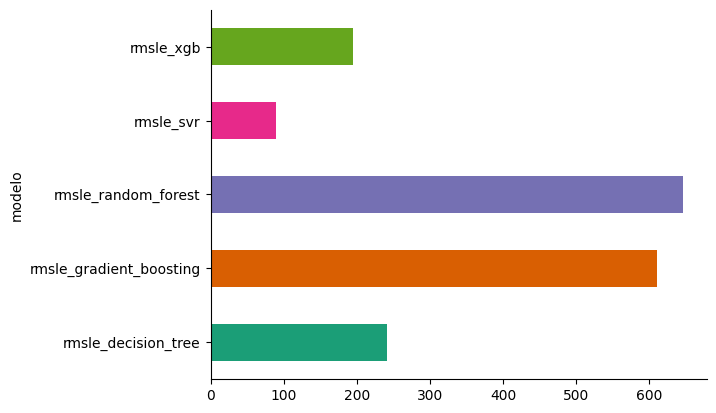

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns
df_best_result.groupby('modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **4. Applying Chosen Models and Predicting Data**


Depending on the model that provided the best result for each subset of data, we will predict the missing data in test_mix (the sales for the next 16 days).

In [40]:
# Iterate over all combinations of store_nbr and family
for store_nbr in store_nbr_values:
    for family in family_values:
        df_name = f"test_mix_{store_nbr}_{family}"
        filtered_df = test_mix[(test_mix['store_nbr'] == store_nbr) & (test_mix['family'] == family)]
        dataframes_list.append((df_name, filtered_df))
        globals()[df_name] = filtered_df

In [41]:
import xgboost as xgb
# List to store dataframes with predictions
predicted_dfs = []

# Define the models to use
models = {
    'rmsle_decision_tree': DecisionTreeRegressor(),
    'rmsle_random_forest': RandomForestRegressor(),
    'rmsle_gradient_boosting': GradientBoostingRegressor(),
    'rmsle_svr': SVR(),
    'rmsle_xgb': xgb.XGBRegressor()
}

# Iterate over each row in df_best_result to make predictions
for index, row in df_best_result.iterrows():
    df_name = row['df_name']
    model_name = row['modelo']
    train_df = globals()[df_name]
    test_df_name = f'test_{df_name.split("_")[1]}_{df_name.split("_")[2]}'
    model = models[model_name]

    # Get the names of training and test sets
    train_df_name = f'train_mix_{df_name.split("_")[2]}_{df_name.split("_")[3]}'
    test_df_name = f'test_mix_{df_name.split("_")[2]}_{df_name.split("_")[3]}'

    # Get training and test dataframes
    train_df = globals()[train_df_name]
    test_df = globals()[test_df_name]

    # Define X_train, Y_train, and X_test
    X_train = train_df.drop(columns=['sales'])
    Y_train = train_df['sales']
    X_test = test_df

    # Train the model on the training data
    model.fit(X_train, Y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Add predictions to the test dataframe
    test_df['sales_predicted'] = y_pred

    # Save the dataframe with predictions to the list
    predicted_dfs.append(test_df[['id', 'sales_predicted']])




Se han truncado las últimas 5000 líneas del flujo de salida.
<ipython-input-41-3d84ab2066de>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-3d84ab2066de>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-3d84ab2066de>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Consolidate the results and save them into a CSV file, adhering to the format specified in 'sample_submission.csv' as detailed in the case overview.

In [42]:
# Combine all prediction dataframes into a single one and sort by 'id'
predicted_df = pd.concat(predicted_dfs, axis=0).sort_values(by='id')
predicted_df['sales_predicted']= predicted_df['sales_predicted'].round(2)
submission = predicted_df.rename(columns={'sales_predicted': 'sales'})[['id', 'sales']].reset_index(drop=True)

file_path= '/content/drive/MyDrive/Proyectos Colab/Store Sales/submission.csv'
submission.to_csv(file_path, index=False)

submission.head()

id   sales
0  3000888    1.36
1  3000889    0.00
2  3000890    5.83
3  3000891  757.96
4  3000892    0.02

# **5.  Conclusions**



1.  **Consideration of Product Substitution:** The previous evaluation does not account for product substitution within product families. Consumers typically choose among different brands or types within the same product family, which influences demand predictions.

2. **Zero Forecasts:** A forecast of zero indicates that the store does not sell that particular product family, which is critical for interpreting the predictions.

3. **Variability in Demand Across Stores and Products:** Demand for product families varies significantly across different stores, emphasizing the need for individualized analyses to achieve prediction accuracy.

4. **Handling Negative Demand Scenarios:** In cases where demand behavior and sales forecasts are negative, predictions are adjusted to zero. This ensures that sales, as a crucial variable, do not contain negative values, thus enhancing the utility of the models.

5. **Exploring Additional Accuracy Metrics:** For future analyses, exploring alternative accuracy metrics such as RMSE could provide a more comprehensive assessment of model performance.





**REFERENCES:**



*   https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide#10.-Simple-Moving-Average



